In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow_core.python.keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt

In [56]:
class InputToCx(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(InputToCx, self).__init__()
        self.output_dim = output_dim

    def call(self, inputs, **kwargs):
        real = tf.cos(inputs)
        imag = tf.sin(inputs)
        return tf.stack([real, imag], axis=1)

In [84]:
class CxMO(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(CxMO, self).__init__()
        self.output_dim = output_dim

    # input[0,:,:] = real
    # input[1,:,:] = image
    def build(self, input_dim):
        self.phi = self.add_variable("phi",
                                     shape=[int(input_dim[-2]),
                                            int(input_dim[-1])])

        super(CxMO, self).build(input_dim)

    def call(self, x):
        x_real = Lambda(lambda x: x[: ,0, :, :], output_shape=self.output_dim)(x)  # real
        x_imag = Lambda(lambda x: x[: ,1, :, :], output_shape=self.output_dim)(x)  # imag
        mo_real = tf.cos(self.phi)
        mo_imag = tf.sin(self.phi)

        real = tf.matmul(x_real, mo_real) - tf.matmul(x_imag, mo_imag)
        imag = tf.matmul(x_real, mo_imag) + tf.matmul(x_imag, mo_real)
        cmpx = tf.stack([real, imag], axis=1)
        return cmpx

In [90]:
class FreeSpacePropagation(tf.keras.layers.Layer):
    def __init__(self, output_dim, pitch_size, z, k):
        super(FreeSpacePropagation, self).__init__()
        self.output_dim = output_dim
        self.pitch_size = pitch_size
        self.z = z
        self.k = k

    def build(self, input_shape):
        x1 = np.arange(0, input_shape[2], 1)
        y1 = np.arange(0, input_shape[1], 1)
        xx1, yy1 = np.meshgrid(x1, y1)
        xx1 = xx1.reshape(1, -1)
        yy1 = yy1.reshape(1, -1)

        x2 = np.arange(0, self.output_dim[1], 1)
        y2 = np.arange(0, self.output_dim[0], 1)
        xx2, yy2 = np.meshgrid(x2, y2)
        xx2 = xx2.reshape(-1, 1)
        yy2 = yy2.reshape(-1, 1)

        dx = self.pitch_size*(xx1 - xx2)
        dy = self.pitch_size*(yy1 - yy2)
        r = np.sqrt(dx**2 + dy**2 + self.z**2)
        w = 1/(2*np.pi) * self.z / r * (1/r - 1j*self.k) * np.exp(1j * self.k * r)

        self.w_real = tf.Variable(initial_value=w.real.astype('float32'),
                                              trainable=False)
        self.w_imag = tf.Variable(initial_value=w.imag.astype('float32'),
                                              trainable=False)

        super(FreeSpacePropagation, self).build(input_shape)

    def call(self, x, **kwargs):
        x_real = Lambda(lambda x: x[:,0, :, :], output_shape=self.output_dim)(x)  # real
        x_imag = Lambda(lambda x: x[:,1, :, :], output_shape=self.output_dim)(x)  # imag
        x_real = tf.reshape(x_real, (-1, 1))
        x_imag = tf.reshape(x_imag, (-1, 1))
        real = tf.matmul(self.w_real, x_real) - tf.matmul(self.w_imag, x_imag)
        imag = tf.matmul(self.w_real, x_imag) + tf.matmul(self.w_imag, x_real)
        print(real.shape)
        real = tf.reshape(real, self.output_dim)
        imag = tf.reshape(imag, self.output_dim)
        cmpx = tf.stack([real, imag], axis=0)
        return cmpx

In [47]:
class CxD2NNDetector(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(CxD2NNDetector, self).__init__(**kwargs)
        self.output_dim = output_dim

    def call(self, x, **kwargs):
        x_real = Lambda(lambda x: x[0, :, :], output_shape=self.output_dim)(x)  # real
        x_imag = Lambda(lambda x: x[1, :, :], output_shape=self.output_dim)(x)
        intensity = tf.sqrt(x_real ** 2 + x_imag **2)



In [48]:
class MOD2NN(tf.keras.Model):
    def __init__(self):
        super(MOD2NN, self).__init__()
        self.l = 633e-9
        self.k = 2 * np.pi / self.l
        self.d = 1e-6
        self.mo1 = CxMO((28, 28))
        self.propag1 = FreeSpacePropagation((28, 28), self.d, 2e-3, self.k)
        self.mo2 = CxMO((28, 28))
        self.prooag2 = FreeSpacePropagation((1, 10), self.d*2, 1e-9, self.k)

    def call(self, inputs):
        x = self.mo1(inputs)
        x = self.propag1(x)
        x = self.mo2(x)
        x = self.prooag2(x)
        x = tf.nn.softmax(x[0,:,:])
        return x


In [41]:
model = MOD2NN()
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [9]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

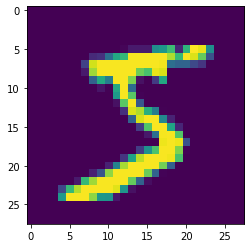

In [38]:
plt.imshow(x_train[0,:,:])

In [91]:
l = 633e-9
k = 2 * np.pi / l
d = 1e-6
inputs = keras.Input((28, 28))
x = InputToCx((28, 28))(inputs)
x = CxMO((28, 28))(x)
x = FreeSpacePropagation((28, 28), d, 2e-3, k)(x)
x.shape

(None, 2, 28, 28)
(None, 28, 28)
(784, 1)


TensorShape([2, 28, 28])

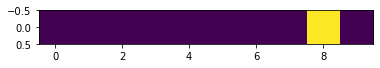

In [40]:
plt.imshow(y[:, :])